ステップ1: ライブラリのインストールとインポートを開始します...
ステップ1: 完了。

ステップ2: シミュレーションパラメータを設定します...
ステップ2: 完了。

ステップ3: シミュレーション関数を定義します...
ステップ3: 完了。

ステップ4: TEOSの軌道計算を実行します。時間がかかります...


TEOSシミュレーション実行中: 100%|██████████| 80001/80001 [02:56<00:00, 452.49it/s]

ステップ4: 完了。

ステップ5: 結果をCSVファイルにまとめ、ダウンロードします...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

『teos_trajectory_data.csv』がダウンロードされました。
ステップ5: 完了。

ステップ6: TEOSの軌道グラフを作成し、PDFファイルとしてダウンロードします...


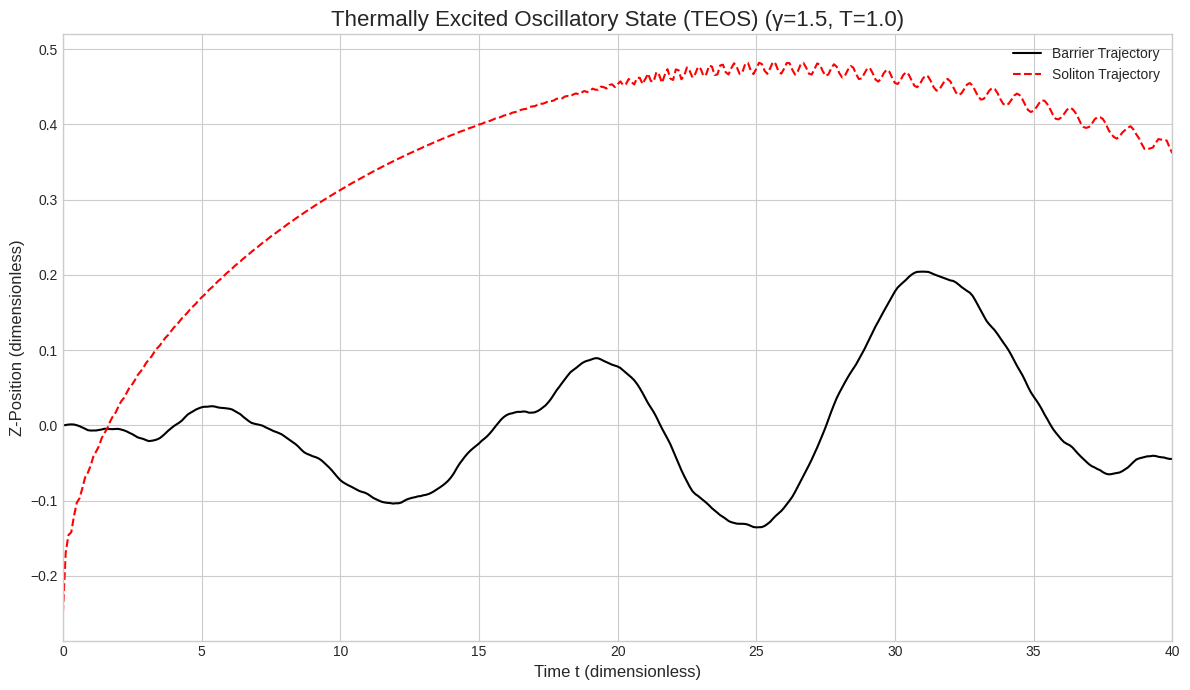

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ステップ6: 完了。『fig2_TEOS.pdf』がダウンロードされました。

【全タスク完了】


In [1]:
# ===================================================================
# 【新生v4.0】Figure 2: 熱的励起振動状態(TEOS)の軌道プロット
# 目的：「散逸＋熱ゆらぎ」環境下 (γ=1.5, T=1.0) での障壁とソリトンの
#       持続的な振動軌道をプロットし、TEOSを視覚的に示す。
# 生成物：
#   1. fig2_TEOS.pdf (論文用グラフ画像)
#   2. teos_trajectory_data.csv (軌道データ)
# ===================================================================

# ステップ1：必要なライブラリのインストールとインポート
# -------------------------------------------------------------------
print("ステップ1: ライブラリのインストールとインポートを開始します...")
# 念のため、環境をクリーンアップしてからインストール
!pip uninstall -y cupy-cuda11x cupy-cuda12x > /dev/null 2>&1
!pip install cupy-cuda12x tqdm > /dev/null 2>&1

import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from google.colab import files
import warnings

# CuPyのUserWarningを抑制
warnings.filterwarnings("ignore", category=UserWarning, module="cupy")
print("ステップ1: 完了。")

# ステップ2：シミュレーションパラメータの設定
# -------------------------------------------------------------------
print("\nステップ2: シミュレーションパラメータを設定します...")

# CPU側(NumPy)でパラメータを定義
L_np = np.array([32.0, 32.0, 128.0])
N_np = np.array([64, 64, 256])
dx_np = L_np / N_np

# GPU側に転送
L = cp.asarray(L_np)
N = cp.asarray(N_np)
dx = cp.asarray(dx_np)

m = 1.0
hbar = 1.0
g = -15.0
omega_perp = 0.1
A = 0.1
sigma = 4.0
M = 50.0
k_mech = 10.0
zb0 = 0.0  # TEOSは原点周りの振動なので初期位置を0に設定
gamma = 1.5
kBT = 1.0

# 時間発展のパラメータ
dt = 0.0005
t_max = 40.0
n_steps = int(t_max / dt)

# 初期状態のパラメータ
kz_kick = 0.15 # 運動のきっかけを与えるための初期キック

print("ステップ2: 完了。")


# ステップ3：シミュレーション関数の定義
# -------------------------------------------------------------------
print("\nステップ3: シミュレーション関数を定義します...")

def run_teos_simulation():
    # 空間・波数グリッドの準備
    x = cp.arange(-L_np[0]/2, L_np[0]/2, dx_np[0])
    y = cp.arange(-L_np[1]/2, L_np[1]/2, dx_np[1])
    z = cp.arange(-L_np[2]/2, L_np[2]/2, dx_np[2])
    X, Y, Z = cp.meshgrid(x, y, z, indexing='ij')

    kx = 2 * cp.pi * cp.fft.fftfreq(int(N_np[0]), d=dx_np[0])
    ky = 2 * cp.pi * cp.fft.fftfreq(int(N_np[1]), d=dx_np[1])
    kz = 2 * cp.pi * cp.fft.fftfreq(int(N_np[2]), d=dx_np[2])
    Kx, Ky, Kz = cp.meshgrid(kx, ky, kz, indexing='ij')
    K2 = Kx**2 + Ky**2 + Kz**2

    # 初期波動関数を複素数型で生成
    V_trap = 0.5 * m * omega_perp**2 * (X**2 + Y**2)
    mu = 0.42
    psi_real = cp.sqrt(cp.maximum(0, (mu - V_trap) / g))
    psi = psi_real.astype(cp.complex128)

    norm = cp.sqrt(cp.sum(cp.abs(psi)**2) * cp.prod(dx))
    psi /= norm
    psi *= cp.exp(1j * kz_kick * Z)

    # 古典場変数はGPU上の0次元配列として初期化
    zb = cp.array(zb0)
    vb = cp.array(0.0)

    # データ保存用配列
    time_points = []
    zb_trajectory = []
    soliton_pos_trajectory = []

    exp_K = cp.exp(-1j * hbar * K2 * dt / (2 * m))

    # 時間発展ループ
    for i in tqdm(range(n_steps + 1), desc="TEOSシミュレーション実行中"):
        V_barrier = A * cp.exp(-(Z - zb)**2 / (2 * sigma**2))
        V_total = V_trap + V_barrier
        psi *= cp.exp(-1j * (V_total + g * cp.abs(psi)**2) * dt / (2 * hbar))

        psi_k = cp.fft.fftn(psi)
        psi_k *= exp_K
        psi = cp.fft.ifftn(psi_k)

        psi *= cp.exp(-1j * (V_total + g * cp.abs(psi)**2) * dt / (2 * hbar))

        dV_dzb = (Z - zb) / sigma**2 * V_barrier
        F_feedback = -cp.sum(cp.abs(psi)**2 * dV_dzb).real * cp.prod(dx)
        F_restoring = -k_mech * (zb - zb0)
        F_thermal = cp.random.normal(0, cp.sqrt(2 * gamma * kBT / dt))
        F_total_t = F_feedback + F_restoring - gamma * vb + F_thermal

        zb_new = zb + vb * dt + 0.5 * F_total_t * dt**2 / M

        V_barrier_new = A * cp.exp(-(Z - zb_new)**2 / (2 * sigma**2))
        dV_dzb_new = (Z - zb_new) / sigma**2 * V_barrier_new
        F_feedback_new = -cp.sum(cp.abs(psi)**2 * dV_dzb_new).real * cp.prod(dx)
        F_restoring_new = -k_mech * (zb_new - zb0)
        F_thermal_new = cp.random.normal(0, cp.sqrt(2 * gamma * kBT / dt))

        F_total_t_plus_1 = F_feedback_new + F_restoring_new - gamma * vb + F_thermal_new

        vb_new = vb + 0.5 * (F_total_t + F_total_t_plus_1) * dt / M

        zb = zb_new
        vb = vb_new

        if i % 200 == 0: # 200ステップごとに記録
            # ソリトンの中心位置を計算
            density = cp.abs(psi)**2
            soliton_pos = cp.sum(Z * density) / cp.sum(density)

            time_points.append(i * dt)
            zb_trajectory.append(zb.get())
            soliton_pos_trajectory.append(soliton_pos.get())

    return time_points, zb_trajectory, soliton_pos_trajectory

print("ステップ3: 完了。")


# ステップ4：シミュレーションの実行とデータ収集
# -------------------------------------------------------------------
print("\nステップ4: TEOSの軌道計算を実行します。時間がかかります...")

time_pts, zb_traj, soliton_traj = run_teos_simulation()

print("ステップ4: 完了。")


# ステップ5：データフレームの作成とCSVファイルのエクスポート
# -------------------------------------------------------------------
print("\nステップ5: 結果をCSVファイルにまとめ、ダウンロードします...")

df = pd.DataFrame({
    'time': time_pts,
    'barrier_z': zb_traj,
    'soliton_z': soliton_traj
})
csv_filename = 'teos_trajectory_data.csv'
df.to_csv(csv_filename, index=False)
files.download(csv_filename)
print(f"『{csv_filename}』がダウンロードされました。")
print("ステップ5: 完了。")


# ステップ6：グラフの作成とPDFファイルのエクスポート
# -------------------------------------------------------------------
print("\nステップ6: TEOSの軌道グラフを作成し、PDFファイルとしてダウンロードします...")

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# --- グラフ描画 ---
ax.plot(df['time'], df['barrier_z'], color='black', linestyle='-', label='Barrier Trajectory')
ax.plot(df['time'], df['soliton_z'], color='red', linestyle='--', label='Soliton Trajectory')

# --- グラフタイトルと軸ラベル ---
ax.set_title('Thermally Excited Oscillatory State (TEOS) (γ=1.5, T=1.0)', fontsize=16)
ax.set_xlabel('Time t (dimensionless)', fontsize=12)
ax.set_ylabel('Z-Position (dimensionless)', fontsize=12)
ax.legend(loc='upper right')
ax.set_xlim(left=0, right=t_max)

fig.tight_layout()

# PDFファイルとして保存
pdf_filename = 'fig2_TEOS.pdf'
plt.savefig(pdf_filename, bbox_inches='tight')
plt.show()

# ダウンロード
files.download(pdf_filename)

print(f"ステップ6: 完了。『{pdf_filename}』がダウンロードされました。")
print("\n【全タスク完了】")